In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from collections import Counter

import scipy
from umap import UMAP
from sklearn.decomposition import PCA

In [2]:
''' defining functions used later within the notebook '''

def str_to_percent(word):
    str_num = re.findall("\d+\.\d+", word)
    if not str_num:
        str_num = re.findall("\d+", word)
    return float(str_num[0]) / 100

def map_hours(df):
    hour_map = {'Not at all': 0, 'Less than 1 hour': 1, '1-2 hours': 2, '3 or more hours': 3}
    df = df.applymap(lambda x: hour_map.get(x) if x in hour_map else x)
    return df

def calc_s(x,y):
    c = Counter(zip(x,y))
    s = [c[(xx,yy)] for xx,yy in zip(x,y)]
    return s

# Stolen from Isabella
def fill_nan_encode_categories(dataframe):
    # replace nan with -1 -> to keep them recognisable
    result = dataframe.fillna(-1)
    # make all columns a category -> even the numerical ones as they are not continuous numbers
    result = result.astype('category')
    # use pd's codes to make them numeric -> -1 disappears this way
    return result.apply(lambda x: x.cat.codes)

In [3]:
raw_df = pd.read_csv("../data/maps-synthetic-data-v1.1.csv")
raw_df.head()

,Unnamed: 0,X,flag,comp_bed_9,mat_dep,mat_age,weight_16,height_16,iq,comp_noint_bed_16,...,dep_score,comp_house,tv_bed_16,creat_14,comp_games,fam_tv_eve,fam_tv_aft,fam_tv_mor,sex,birth_order
0,1,1,synthetic,NaN,3.0,30,59.294132,181.602831,107.0,NaN,...,0.0,Yes,Yes,often,No,"Yes, Some Days",Other,"Yes, Every Day",Female,A
1,2,2,synthetic,NaN,9.0,26,NaN,NaN,85.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,B
2,3,3,synthetic,NaN,3.0,24,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"Yes, Some Days","Yes, Every Day",Other,Male,A
3,4,4,synthetic,No,NaN,22,49.812426,160.224186,NaN,NaN,...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,Male,A
4,5,5,synthetic,No,8.0,31,62.270030,191.703227,132.0,Yes,...,NaN,NaN,NaN,often,No,"Yes, Some Days","Yes, Every Day","Yes, Every Day",Female,A


Looking into negative correlation from dep_score and others

Dep_score = Child's depression score on CIS-R at 17.5 years old.

Columns thought to be negatively correlated:

musi_week = Average time child spent per day playing musical instruments on a typical weekday

musi_wend = Average time child spent per day playing musical instruments on a typical weekend day

read_week = Average time child spent per day reading books for pleasure on a typical weekday

read_wend = Average time child spent per day reading books for pleasure on a typical weekend day

out_sum_week = Average time child spent per day out of doors in summer on a typical weekday

out_sum_wend = Average time child spent per day out of doors in summer on a typical weekend day

out_win_week = Average time child spent per day out of doors in winter on a typical weekday

out_win_wend = Average time child spent per day out of doors in winter on a typical weekend day

In [4]:
columns = ['has_dep_diag','dep_score','dep_thoughts','secd_diag', 
           'musi_week', 'musi_wend', 'read_week', 'read_wend', 'draw_week', 'draw_wend',
           'out_sum_week','out_sum_wend', 'out_win_week', 'out_win_wend']

In [5]:
df = raw_df[columns]
df.shape

(13734, 14)

In [6]:
# Shamelessly stolen from Isabella
# replace nan with -1 -> to keep them recognisable
df = fill_nan_encode_categories(df)
df.columns

Index(['has_dep_diag', 'dep_score', 'dep_thoughts', 'secd_diag', 'musi_week',
       'musi_wend', 'read_week', 'read_wend', 'draw_week', 'draw_wend',
       'out_sum_week', 'out_sum_wend', 'out_win_week', 'out_win_wend'],
      dtype='object')

<AxesSubplot:xlabel='out_win_wend', ylabel='has_dep_diag'>

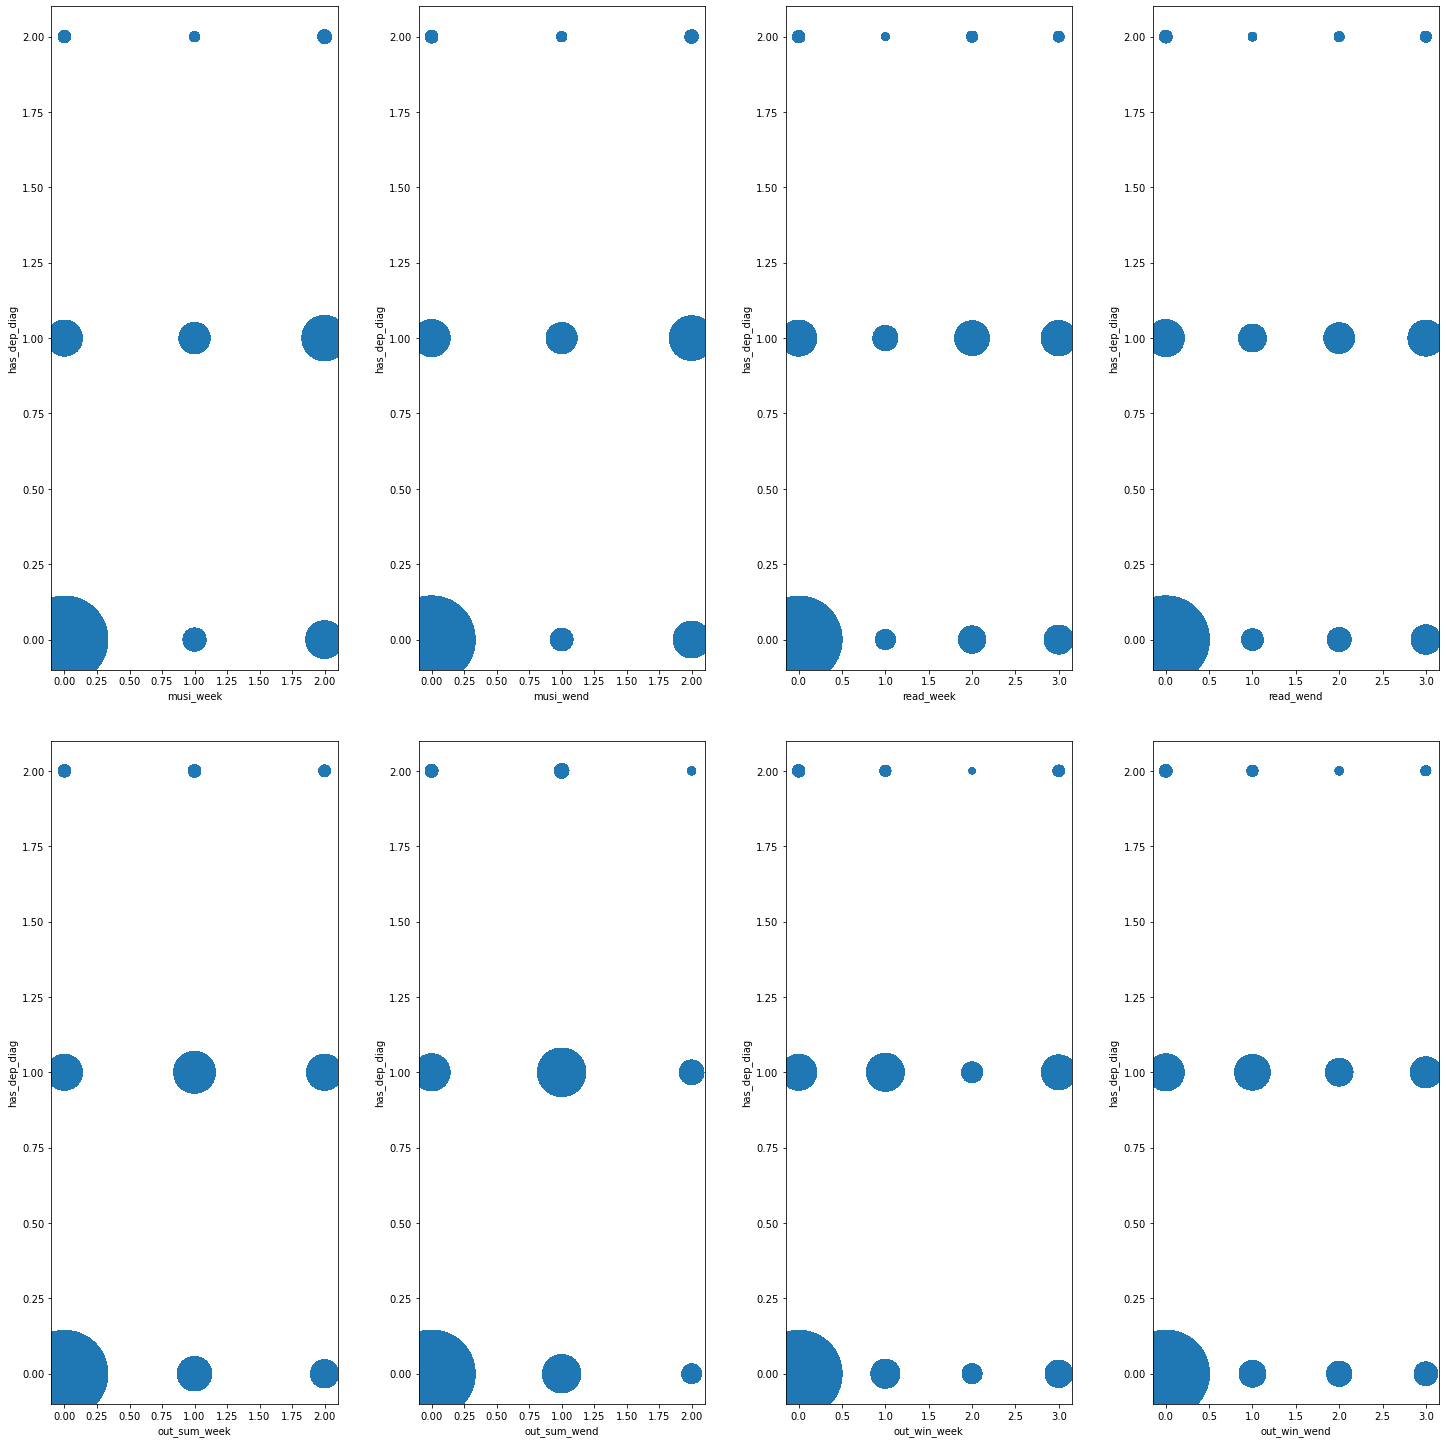

In [7]:
x = df['has_dep_diag']

plt.rcParams["figure.figsize"] = [20, 20]

fig, axes = plt.subplots(nrows=2, ncols=4)
fig.tight_layout(h_pad=5, w_pad=5)

y = df['musi_week']
df.plot(kind='scatter', x='musi_week',y='has_dep_diag',s=calc_s(x,y), ax=axes[0,0])
y = df['musi_wend']
df.plot(kind='scatter', x='musi_wend',y='has_dep_diag',s=calc_s(x,y), ax=axes[0,1])
y = df['read_week']
df.plot(kind='scatter', x='read_week',y='has_dep_diag',s=calc_s(x,y), ax=axes[0,2])
y = df['read_wend']
df.plot(kind='scatter', x='read_wend',y='has_dep_diag',s=calc_s(x,y), ax=axes[0,3])
y = df['out_sum_week']
df.plot(kind='scatter', x='out_sum_week',y='has_dep_diag',s=calc_s(x,y), ax=axes[1,0])
y = df['out_sum_wend']
df.plot(kind='scatter', x='out_sum_wend',y='has_dep_diag',s=calc_s(x,y), ax=axes[1,1])
y = df['out_win_week']
df.plot(kind='scatter', x='out_win_week',y='has_dep_diag',s=calc_s(x,y), ax=axes[1,2])
y = df['out_win_wend']
df.plot(kind='scatter', x='out_win_wend',y='has_dep_diag',s=calc_s(x,y), ax=axes[1,3])

In [8]:
cov_matrix = df.cov()
cov_matrix.head()

,has_dep_diag,dep_score,dep_thoughts,secd_diag,musi_week,musi_wend,read_week,read_wend,draw_week,draw_wend,out_sum_week,out_sum_wend,out_win_week,out_win_wend
has_dep_diag,0.286198,0.405394,0.370844,0.412764,0.195951,0.191468,0.258412,0.250233,0.253134,0.260206,0.170859,0.139782,0.230158,0.220601
dep_score,0.405394,0.739026,0.743506,0.678135,0.265108,0.257157,0.351147,0.340661,0.341865,0.352468,0.231853,0.190011,0.315783,0.299664
dep_thoughts,0.370844,0.743506,1.213071,0.729359,0.223756,0.219780,0.291657,0.285801,0.286209,0.299668,0.190211,0.159080,0.268414,0.253452
secd_diag,0.412764,0.678135,0.729359,0.969525,0.240049,0.233579,0.318204,0.308518,0.307926,0.316808,0.210064,0.171583,0.284421,0.271960
musi_week,0.195951,0.265108,0.223756,0.240049,0.745933,0.703997,0.881337,0.848901,0.857448,0.884254,0.545781,0.449642,0.749282,0.715987


<AxesSubplot:>

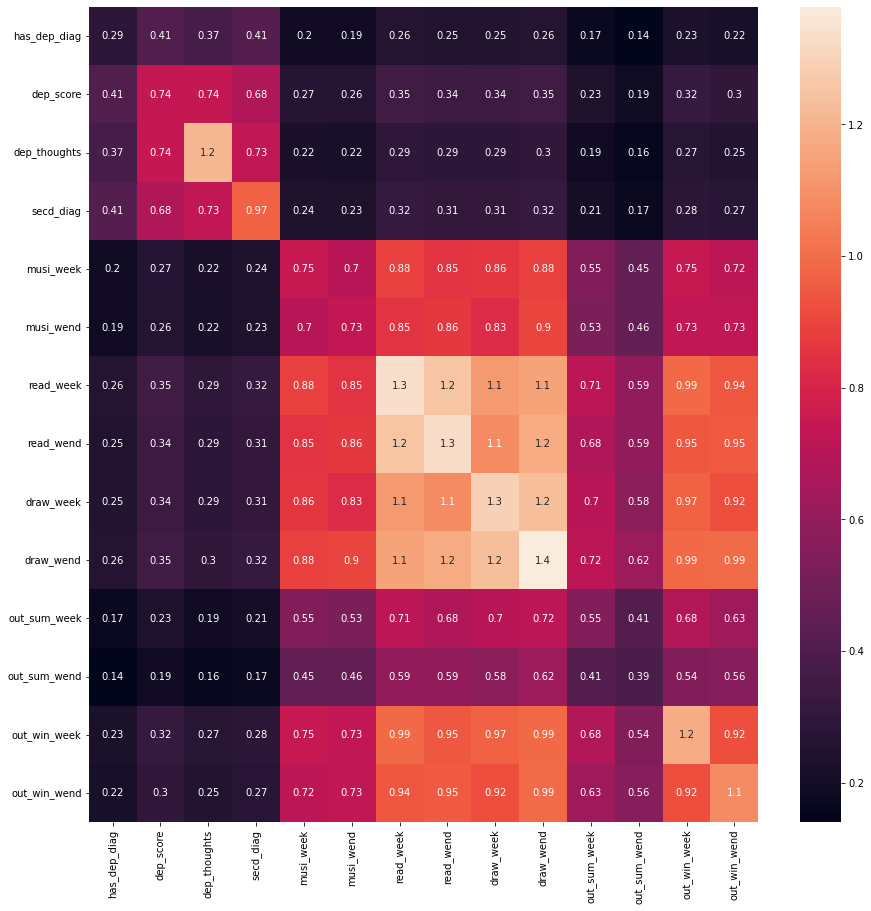

In [9]:
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 15]
sns.heatmap(cov_matrix, annot=True)

<AxesSubplot:>

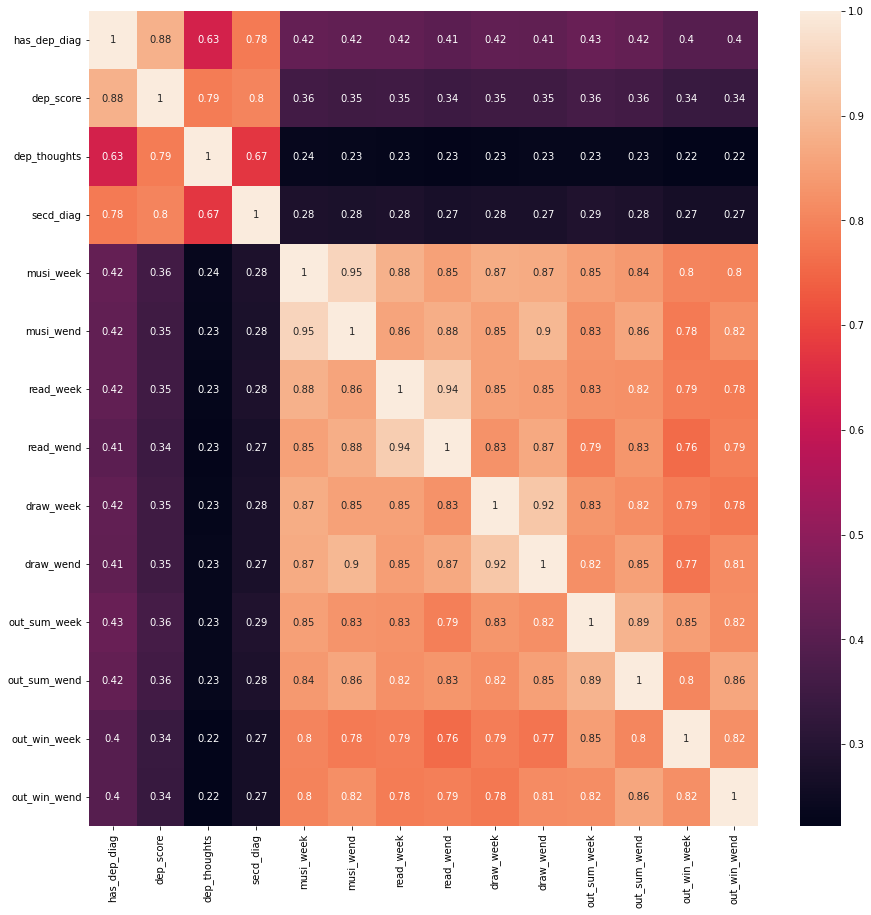

In [10]:
# Correlation matrix
corr_matrix = df.corr()#method='spearman')
plt.rcParams["figure.figsize"] = [15, 15]
sns.heatmap(corr_matrix, annot=True)

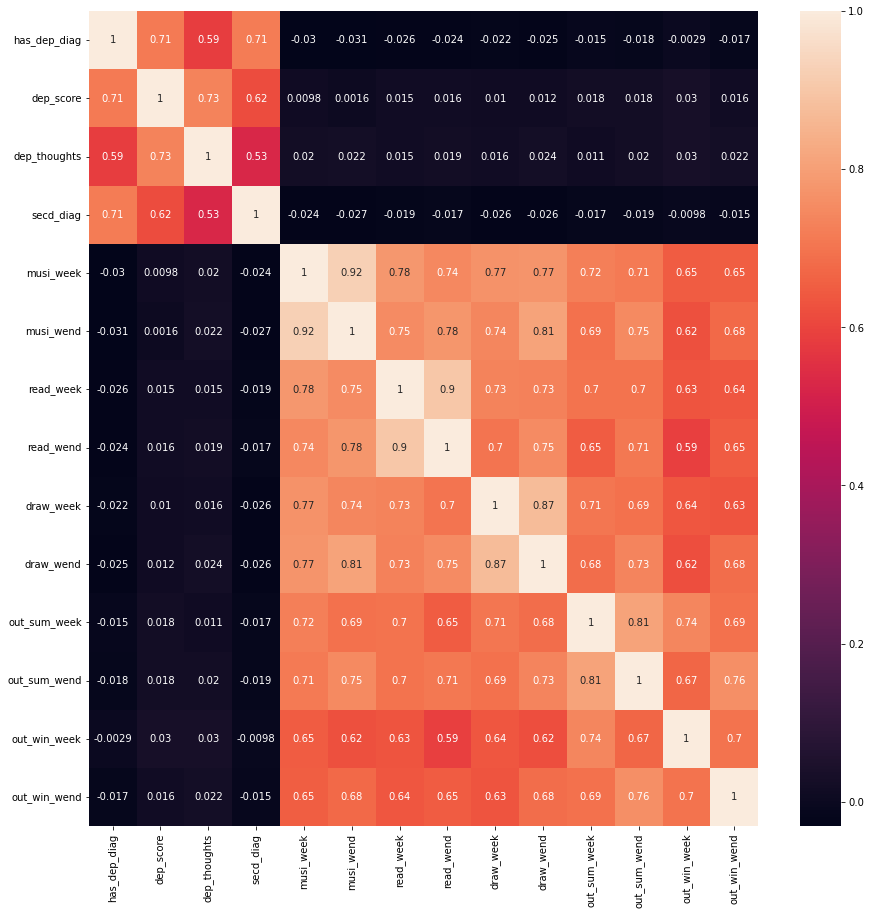

In [12]:
# Making a new dataframe where each row has at least one diagnoses column that is not a NaN.
# Checking to see if this makes a difference, to make the columns more correlated?
diag_cols = ['has_dep_diag',
             'dep_score',
             'dep_thoughts',
             'secd_diag']

df = raw_df.dropna(how="all", subset=diag_cols)
df = df[columns]
df = fill_nan_encode_categories(df)

corr_matrix = df.corr()#method='spearman')
plt.rcParams["figure.figsize"] = [15, 15]
snsplot = sns.heatmap(corr_matrix, annot=True)

plot2save = snsplot.get_figure()
plot2save.savefig("output.png")

In [ ]:
x = df['has_dep_diag']

plt.rcParams["figure.figsize"] = [20, 20]

fig, axes = plt.subplots(nrows=2, ncols=4)
fig.tight_layout(h_pad=5, w_pad=5)

y = df['musi_week']
df.plot(kind='scatter', x='musi_week',y='has_dep_diag',s=calc_s(x,y), ax=axes[0,0])
y = df['musi_wend']
df.plot(kind='scatter', x='musi_wend',y='has_dep_diag',s=calc_s(x,y), ax=axes[0,1])
y = df['read_week']
df.plot(kind='scatter', x='read_week',y='has_dep_diag',s=calc_s(x,y), ax=axes[0,2])
y = df['read_wend']
df.plot(kind='scatter', x='read_wend',y='has_dep_diag',s=calc_s(x,y), ax=axes[0,3])
y = df['out_sum_week']
df.plot(kind='scatter', x='out_sum_week',y='has_dep_diag',s=calc_s(x,y), ax=axes[1,0])
y = df['out_sum_wend']
df.plot(kind='scatter', x='out_sum_wend',y='has_dep_diag',s=calc_s(x,y), ax=axes[1,1])
y = df['out_win_week']
df.plot(kind='scatter', x='out_win_week',y='has_dep_diag',s=calc_s(x,y), ax=axes[1,2])
y = df['out_win_wend']
df.plot(kind='scatter', x='out_win_wend',y='has_dep_diag',s=calc_s(x,y), ax=axes[1,3])

## Random Machine Learning to see what happens

In [13]:
# ml_columns = ['has_dep_diag', 
           # 'musi_week', 'musi_wend', 'read_week', 'read_wend', 'out_sum_week','out_sum_wend', 'out_win_week', 'out_win_wend']

ml_columns = ['has_dep_diag',
           # 'dep_score',
           # 'dep_thoughts',
           # 'secd_diag',
           'talk_mob_week',
           'talk_mob_wend',
           'text_week',
           'text_wend',
           'tv_week',
           'tv_wend',
           'comp_week',
           'comp_wend']

df = raw_df[ml_columns]

In [14]:
df = df.dropna(subset=['has_dep_diag'])
df = df.astype('category')
df = df.apply(lambda x: x.cat.codes)

In [15]:
from sklearn.model_selection import train_test_split

y = df['has_dep_diag']
X = df.drop('has_dep_diag', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Using a Dummy Classifier as a baseline ... The dummy classifier we are using will simply predict the majority class.

In [16]:
#Dummy Classifier

from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy= 'most_frequent').fit(X_train,y_train)

y_pred = model.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, mean_absolute_error

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('Mean Absolute Error : ' + str(mean_absolute_error(y_test,y_pred)))

Accuracy Score : 0.9136212624584718
Precision Score : 0.0
Recall Score : 0.0
F1 Score : 0.0
Mean Absolute Error : 0.08637873754152824


/Users/jr20844/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
from sklearn.metrics import confusion_matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Confusion Matrix : 
[[825   0]
 [ 78   0]]


Model predicts no depression on all predictions, which gives a high accuracy, because this is true most of the time.

Since the model does not classify any positive depression cases correctly, the recall and precision metrics are 0.

## Lets try with actual models

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# model = LinearRegression()
model = LogisticRegression()
model.fit(X_train,y_train)

pred = model.predict(X_test)

In [20]:
from sklearn.model_selection import GridSearchCV

grid_values = {'penalty': ['l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}

grid_clf_acc = GridSearchCV(model, param_grid = grid_values,scoring = 'recall', error_score='raise')
grid_clf_acc.fit(X_train, y_train)

GridSearchCV(error_score='raise', estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l2']},
             scoring='recall')

In [21]:
y_pred_acc = grid_clf_acc.predict(X_test)

In [22]:
y_pred_acc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))
print('Mean Absolute Error : ' + str(mean_absolute_error(y_test,y_pred_acc)))

from sklearn.metrics import confusion_matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_acc)))

In [ ]:
hm = sns.heatmap(confusion_matrix(y_test,y_pred_acc), annot=True).get_figure()
# hm.savefig("hm.png")

In [ ]:
ml_columns = ['has_dep_diag',
           # 'dep_score',
           # 'dep_thoughts',
           # 'secd_diag',
           'talk_mob_week',
           'talk_mob_wend',
           'text_week',
           'text_wend',
           'tv_week',
           'tv_wend',
           'comp_week',
           'comp_wend']

In [ ]:
df = raw_df[(raw_df['iq'] > 120)]
df = df[ml_columns]

In [ ]:
df = df.dropna(subset=['has_dep_diag'])
df = df.astype('category')
df = df.apply(lambda x: x.cat.codes)

In [ ]:
importance = model.coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# svc = LinearSVC(dual=False, random_state=123)
# params_grid = {"C": [10 ** k for k in range(-3, 4)]}
# clf = GridSearchCV(svc, params_grid)
# clf.fit(X_train, y_train)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))
print('Mean Absolute Error : ' + str(mean_absolute_error(y_test,y_pred_acc)))

In [ ]:
umap = UMAP(n_neighbors=500,verbose=True)
pipeline = Pipeline([("umap", umap), ("model", model)])


clf_pipeline = GridSearchCV(pipeline)
clf_pipeline.fit(X_train, y_train)

In [ ]:
clf_pipeline = GridSearchCV(pipeline)
clf_pipeline.fit(X_train, y_train)
print(
    "Accuracy on the test set with UMAP transformation: {:.3f}".format(
        clf_pipeline.score(X_test, y_test)
    )
)